# Zadanie 5

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]


In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.9,
        gamma: float = 0.9,
        epsilon: float = 0.1,
        q_table: np.ndarray = None,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        if q_table is None:
            self.q_table = np.zeros(shape=(observation_space, action_space))
        else:
            self.q_table = q_table

    def __call__(self, state: np.ndarray, action: np.ndarray) -> float:
        """Return Q-value of given state and action."""
        return self.q_table[state][action]

    def update(self, state: np.ndarray, action: np.ndarray, reward: float) -> None:
        """Update Q-value of given state and action."""
        self.q_table[state][action] += reward

    def get_best_action(self, state: np.ndarray) -> int:
        """Return action that maximizes Q-value for a given state."""
        return np.argmax(self.q_table[state])

    def get_best_move_evaluation(self, state: np.array) -> float:
        return np.max(self.q_table[state])

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        pass

    def __str__(self):
        return self.__repr__()

In [3]:
def run_episode(solver: QLearningSolver, environment):
    """
    Episode starts in random state.
    Then decide whether to use q_table or make perform random action.
    Get the reward of chosen action and update the q_table.
    """
    state = environment.reset()[0]
    terminated, truncated = False, False
    while not terminated and not truncated:
        if np.random.random() < solver.epsilon:
            action = environment.action_space.sample()
        else:
            action = solver.get_best_action(state)

        next_state, reward, terminated, truncated, _ = environment.step(action)
        delta = (
            reward
            + solver.gamma * solver.get_best_move_evaluation(next_state)
            - solver(state, action)
        )
        solver.update(state, action, solver.learning_rate * delta)
        state = next_state


def q_learning(
    environment, learning_rate=0.9, gamma=0.9, epsilon=0.1, number_of_episodes=1000
):
    """
    Run n episodes, which will allow QLearningSolver with specified parameters to learn
    """
    solver = QLearningSolver(
        environment.observation_space.n,
        environment.action_space.n,
        learning_rate,
        gamma,
        epsilon,
    )
    for _ in range(number_of_episodes):
        run_episode(solver, environment)
    return solver

In [36]:
def test_solver(solver: QLearningSolver, environment, number_of_tests: int = 1000):
    """
    Method for testing QLearningSolvers;
    Checks whether a solver can reach the reward from a random state n times.
    Returns the success rate and average number of steps.
    """
    successes = 0
    total_steps = 0
    for _ in range(number_of_tests):
        state = environment.reset()[0]
        terminated, truncated = False, False
        steps = 0
        while not terminated and not truncated:
            action = solver.get_best_action(state)
            next_state, reward, terminated, truncated = environment.step(action)[:4]
            state = next_state
            steps += 1
        if terminated and reward > 0:
            successes += 1
        total_steps += steps
    return successes / number_of_tests, total_steps / number_of_tests

In [37]:
def run_experiment(
    env, learning_rate=0.9, gamma=0.9, epsilon=0.1, number_of_episodes=1000
):
    solver = q_learning(env, learning_rate, gamma, epsilon, number_of_episodes)
    success_rate, average_number_of_steps = test_solver(solver, env)
    print("LEARNING:")
    print(
        f"Learning rate: {learning_rate}, gamma: {gamma}, epsilon: {epsilon}, number of episodes: {number_of_episodes}"
    )
    print("TESTING:")
    print(
        f"Success Rate: {success_rate}\nAverage number of steps: {average_number_of_steps}"
    )
    return success_rate, average_number_of_steps
    

# Testy

In [6]:
env = gym.make("Taxi-v3")

In [114]:
def create_scatter_plots(parameter, episodes = 1000):
    parameters = np.array([x for x in range(1, 11)])/10
    success_rates = np.array([0.0] * 10)
    average_numbers_of_steps = np.array([0.0] * 10)
    if parameter == "learning rate":
        for i in range(10):
            success_rates[i], average_numbers_of_steps[i] = run_experiment(env, learning_rate=parameters[i], number_of_episodes = episodes)
    elif parameter == "gamma":
        for i in range(10):
            success_rates[i], average_numbers_of_steps[i] = run_experiment(env, gamma=parameters[i], number_of_episodes = episodes)
    elif parameter == "epsilon":
        for i in range(10):
           success_rates[i], average_numbers_of_steps[i] = run_experiment(env, epsilon=parameters[i], number_of_episodes = episodes)
    else:
        raise Exception("Hyperparameter does not exist")
    fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(13,6.15))
    if parameter == "learning rate":
         fig.text(0.35, 0 ,f"number of learning episodes: {episodes}, gamma = 0.9, epsilon = 0.1")
    elif parameter == "gamma":
        fig.text(0.35, 0 ,f"number of learning episodes: {episodes}, learning rate = 0.9, epsilon = 0.1")
    elif parameter == "epsilon":
        fig.text(0.35, 0 ,f"number of learning episodes: {episodes}, learning rate = 0.9, gamma = 0.9")
        for i in range(10):
           success_rates[i], average_numbers_of_steps[i] = run_experiment(env, epsilon=parameters[i], number_of_episodes = episodes)
    ax[0].scatter(parameters, success_rates, color="green")
    ax[0].set_xlabel(f"{parameter}")
    ax[0].set_ylabel("Success Rate")
    ax[0].set_ylim(0.0, 1.1)
    ax[0].set_title(f"Success rate with different {parameter} parameter")
    ax[1].scatter(parameters, average_numbers_of_steps)
    ax[1].set_xlabel(f"{parameter}")
    ax[1].set_ylabel("Average number of steps")
    ax[1].set_ylim(0, 130)
    ax[1].set_title(f"Average number of steps with different {parameter} parameter")
    plt.show()

LEARNING:
Learning rate: 0.1, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.409
Average number of steps: 122.665
LEARNING:
Learning rate: 0.2, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.761
Average number of steps: 57.152
LEARNING:
Learning rate: 0.3, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.932
Average number of steps: 25.472
LEARNING:
Learning rate: 0.4, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.929
Average number of steps: 26.233
LEARNING:
Learning rate: 0.5, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.968
Average number of steps: 19.071
LEARNING:
Learning rate: 0.6, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.976
Average number of steps: 17.514
LEARNING:
Learning rate: 0.7, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.991
Average number of steps: 14.84
LEARNI

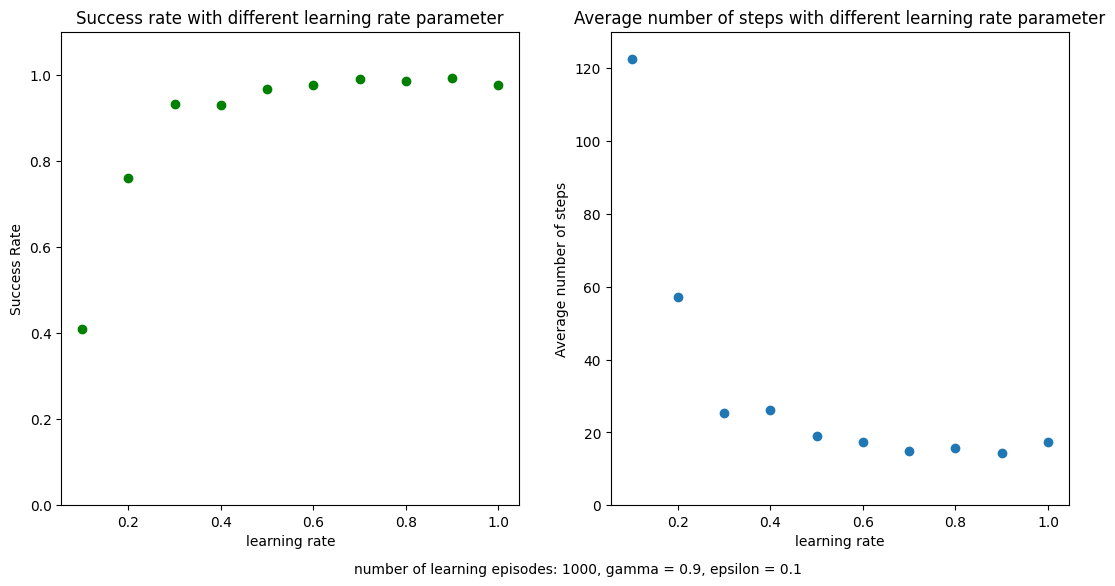

In [115]:
create_scatter_plots("learning rate", 1000)

LEARNING:
Learning rate: 0.9, gamma: 0.1, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.857
Average number of steps: 39.499
LEARNING:
Learning rate: 0.9, gamma: 0.2, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.897
Average number of steps: 32.213
LEARNING:
Learning rate: 0.9, gamma: 0.3, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.888
Average number of steps: 33.76
LEARNING:
Learning rate: 0.9, gamma: 0.4, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.935
Average number of steps: 25.01
LEARNING:
Learning rate: 0.9, gamma: 0.5, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.972
Average number of steps: 18.095
LEARNING:
Learning rate: 0.9, gamma: 0.6, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.944
Average number of steps: 23.349
LEARNING:
Learning rate: 0.9, gamma: 0.7, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.97
Average number of steps: 18.916
LEARNING:

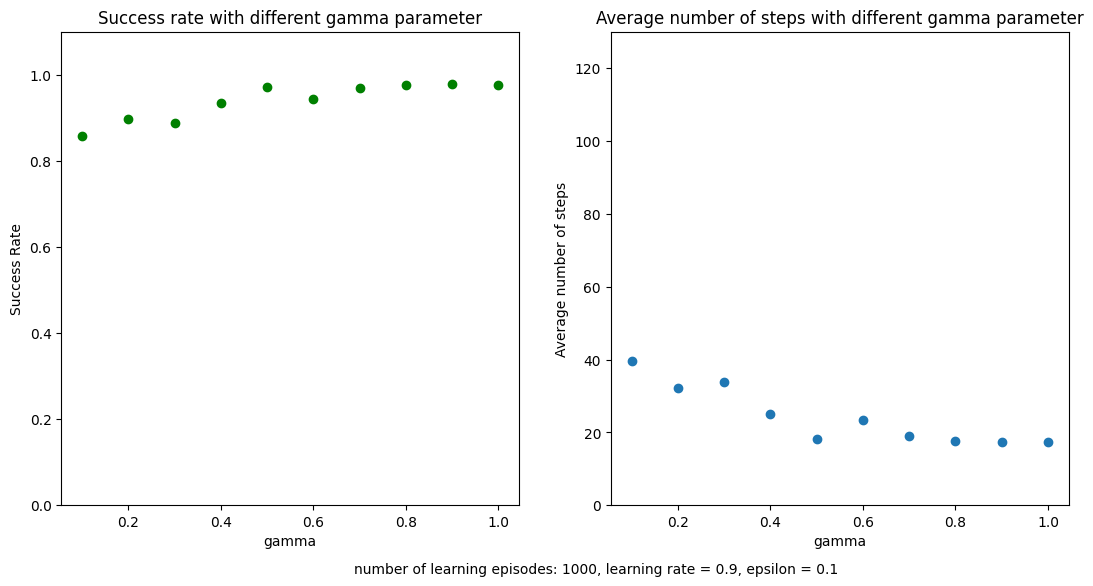

In [116]:
create_scatter_plots("gamma", 1000)

LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.1, number of episodes: 1000
TESTING:
Success Rate: 0.969
Average number of steps: 18.89
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.2, number of episodes: 1000
TESTING:
Success Rate: 0.991
Average number of steps: 14.817
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.3, number of episodes: 1000
TESTING:
Success Rate: 0.973
Average number of steps: 18.075
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.4, number of episodes: 1000
TESTING:
Success Rate: 1.0
Average number of steps: 13.031
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.5, number of episodes: 1000
TESTING:
Success Rate: 0.992
Average number of steps: 14.674
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.6, number of episodes: 1000
TESTING:
Success Rate: 0.998
Average number of steps: 13.555
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.7, number of episodes: 1000
TESTING:
Success Rate: 1.0
Average number of steps: 12.963
LEARNING:
L

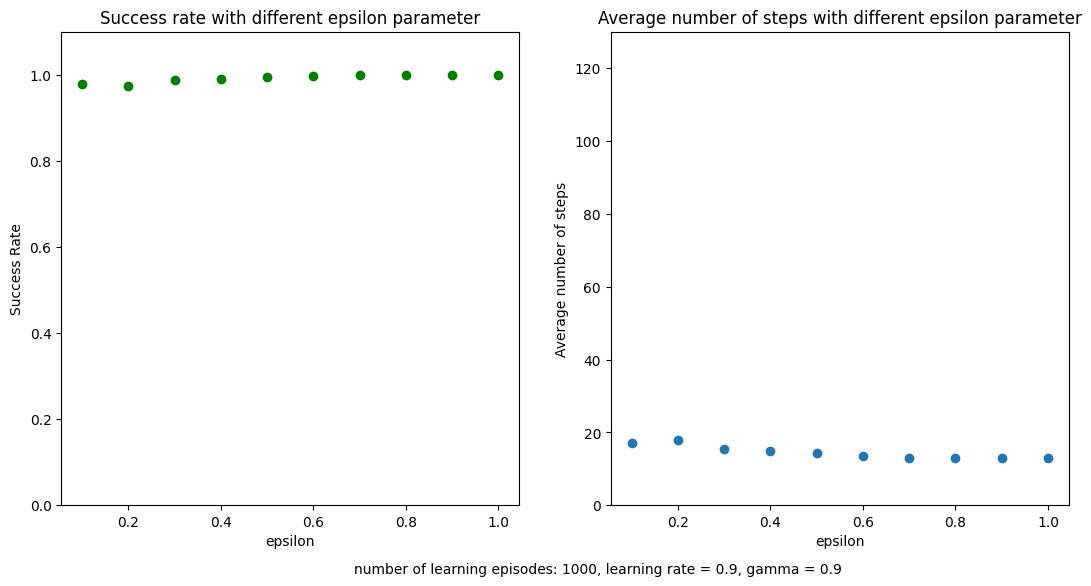

In [117]:
create_scatter_plots("epsilon", 1000)

LEARNING:
Learning rate: 0.9, gamma: 0.1, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.569
Average number of steps: 92.825
LEARNING:
Learning rate: 0.9, gamma: 0.2, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.635
Average number of steps: 80.576
LEARNING:
Learning rate: 0.9, gamma: 0.3, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.696
Average number of steps: 69.309
LEARNING:
Learning rate: 0.9, gamma: 0.4, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.742
Average number of steps: 60.612
LEARNING:
Learning rate: 0.9, gamma: 0.5, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.779
Average number of steps: 53.959
LEARNING:
Learning rate: 0.9, gamma: 0.6, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.82
Average number of steps: 46.397
LEARNING:
Learning rate: 0.9, gamma: 0.7, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.88
Average number of steps: 35.278
LEARNING:
Learn

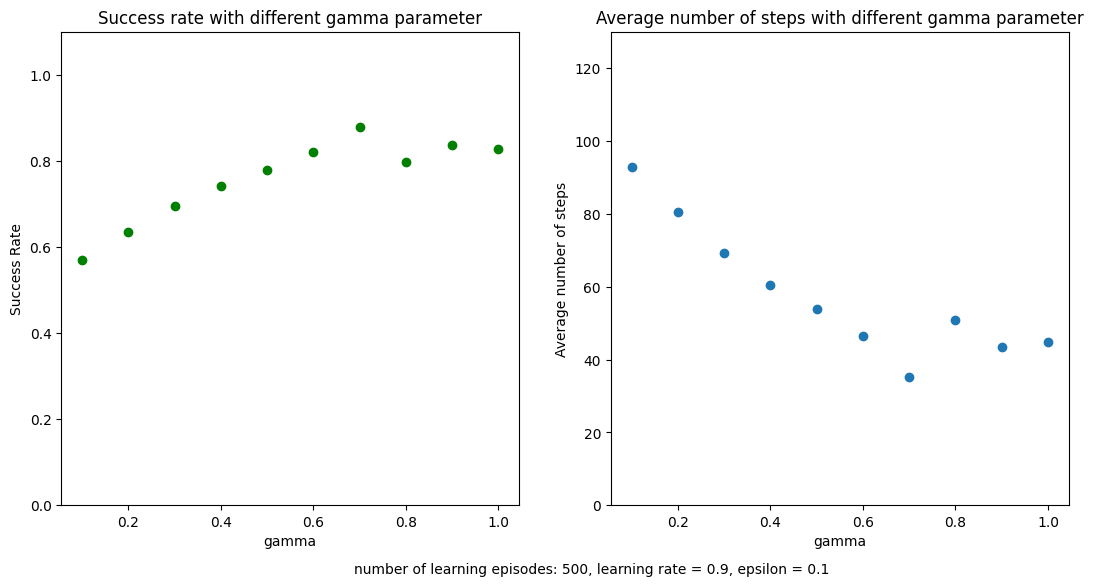

In [118]:
create_scatter_plots("gamma", 500)

LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.1, number of episodes: 500
TESTING:
Success Rate: 0.839
Average number of steps: 42.911
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.2, number of episodes: 500
TESTING:
Success Rate: 0.841
Average number of steps: 42.541
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.3, number of episodes: 500
TESTING:
Success Rate: 0.919
Average number of steps: 28.139
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.4, number of episodes: 500
TESTING:
Success Rate: 0.857
Average number of steps: 39.661
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.5, number of episodes: 500
TESTING:
Success Rate: 0.876
Average number of steps: 36.132
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.6, number of episodes: 500
TESTING:
Success Rate: 0.969
Average number of steps: 18.792
LEARNING:
Learning rate: 0.9, gamma: 0.9, epsilon: 0.7, number of episodes: 500
TESTING:
Success Rate: 0.97
Average number of steps: 18.748
LEARNING:
Lear

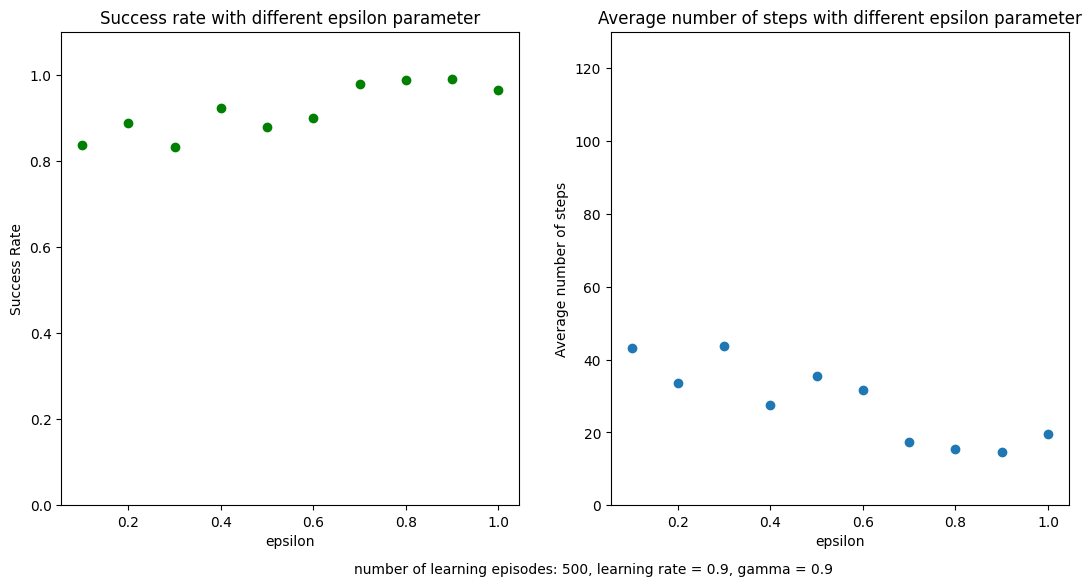

In [119]:
create_scatter_plots("epsilon", 500)

In [120]:
solver = q_learning(
    env, learning_rate=0.9, gamma=0.9, epsilon=0.4, number_of_episodes=3000
)
np.save("solver", solver.q_table)

# Wnioski

Skuteczność algorytmu QLearning w dużym stopniu zależy od poziomu skomplikowania środowisk i odpowiedniego doboru hiperparametrów. 

Jeśli epsilon jest zbyt mały, przestrzeń nie będzie eksplorowana w odpowiednim stopniu, jednak jeśli epsilon będzie zbyt duży, zdobyta wiedza będzie wykorzystywana w małym stopniu, a co za tym idzie algorytm może nie dojść do stanu akceptującego w rozsądnym czasie.

Zbyt duży learning rate powoduje, że to czego algorytm nauczy się w początkowych epizodach może zostać zapomniane w trakcie późniejszych epizodów, co poskutkuje obniżeniem skuteczności. Jednak mniejszy learning rate, sprawia że potrzeba większej liczby epizodów trenujących do uzyskania satysfakcjonujących wyników. 

Gamma jest odpowiedzialna za szybkość dążenia do potencjalnych nagród. Duża wartość parametru, wskazuje że preferowane są większe nagrody, nawet jeśli do ich uzysania należy poświęcić więcej wysiłku (preferencja nagród długoterminowych). Zbyt duża wartość gammy prowadzi do małej eksploatacji, natomiast zbyt mała gamma prowadzi do za małej eksploracji.

W skomplikowanych środowiskach pomocne okazać się może zmniejszanie hiperparametrów epsilon i learning rate wraz ze wzrostem wiedzy na temat środowiska, a także zmniejszanie parametru gamma w późniejszych fazach każdego epizodu. Zmniejszanie epsilonu pozwala na wykorzystanie zdobytej wiedzy, dzięki czemu algorytm nie musi się uczyć kilka razy tych samych ścieżek. Dzięki zmniejszeniu learning rate algorytm nie zapomina informacji, które zdobył w trakcie wcześniejszych epizodów. Stopniowe zmniejszanie parametru gamma w każdym epizodzie może pozwolić na preferowanie szybkich nagród, w późniejszych fragmentach epizodu, czyli kiedy algorytm nie ma dużo czasu na próby zdobycia nagród długoterminowych.

Odpowiedni dobór hiperparametrów (i ich modyfikacja w trkacie uczenia) może okazać się trudnym zadaniam, ponieważ trudno przewidzieć jaka jest najwyższa skuteczność, jaką może osiągnąć agent, w szczególności jeśli akcje są niedeterministyczne.